**Анализ автомобильных аварий и ДТП в России**

Проверим гипотезы:
1. Большинство аварий происходит зимой и в межсезонье.
2. Большинство аварий происходит из-за плохой погоды (дождь, снег).
3. Дорожное покрытие влияет на количество аварий и тяжесть последствий ДТП.
4. Количество аварий и тяжесть последствий ДТП зависят от освещения на дорогах.


In [1228]:
from google.colab import drive
drive.mount ('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import re
import os
import geopandas as gpd
from shapely.geometry import Point
import json
import requests
import warnings
warnings.filterwarnings('ignore')

Данные получены с сайта http://stat.gibdd.ru/

Data.csv - результат объединения 1027 таблиц в формате csv. Количество строк - 336311, количество столбцов - 36.


In [1230]:
df = pd.read_csv('/content/drive/MyDrive/Data/Data.csv', sep=',')
df

,Номер,Дата,Время,Схема,Широта,Долгота,Номер ДТП,Вид ДТП,Адрес,Дорога,...,Сведения об оставлении места ДТП,"Расположение руля, тип привода",Тип ТС,Год выпуска,Марка/модель ТС,Форма собственности,Цвет,Места повреждения,Технические неисправности,Unnamed: 35
0,1.0,31.01.2025,19:00,840.0,50.684200,36.475100,140000837.0,Наезд на пешехода,БЕЛГОРОДСКИЙ РАЙОН,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Осталось на месте ДТП,С передним приводом,Прочие легковые автомобили,2008.0,CHEVROLET Прочие модели Chevrolet,Физические лица,Синий,NaN,Технические неисправности отсутствуют,NaN
2,2.0,31.01.2025,13:45,190.0,50.788300,37.884300,140000818.0,Столкновение,НОВООСКОЛЬСКИЙ РАЙОН,а/д Обход города Новый Оскол,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Осталось на месте ДТП,С передним приводом,"В-класс (малый) до 3,9 м",2002.0,"ВАЗ Жигули ВАЗ-2108, 09 и модификации ...",Физические лица,Зеленый,NaN,Технические неисправности отсутствуют,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Осталось на месте ДТП,С передним приводом,Прочие легковые автомобили,2008.0,DAEWOO Nexia,Физические лица,Красный,NaN,Технические неисправности отсутствуют,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Осталось на месте ДТП,С передним приводом,"В-класс (малый) до 3,9 м",2004.0,"ВАЗ ВАЗ 2110, 21101, 21102, 21103, 21108",Физические лица,Черный,NaN,Технические неисправности отсутствуют,NaN
336307,233.0,01.12.2024,03:30,840.0,51.497028,44.480016,630022028.0,Наезд на пешехода,Калининский р-н,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Скрылось с места ДТП,NaN,"В-класс (малый) до 3,9 м",NaN,,NaN,NaN,NaN,Технические неисправности отсутствуют,NaN
336309,234.0,01.12.2024,05:10,930.0,52.012775,47.770797,630019891.0,Наезд на препятствие,Балаковский р-н,"Р-228, подъезд к Балаковской АЭС, км 0+000 - к...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336311 entries, 0 to 336310
Data columns (total 36 columns):
 #   Column                                                                                                                                                                                       Non-Null Count   Dtype  
---  ------                                                                                                                                                                                       --------------   -----  
 0   Номер                                                                                                                                                                                        125205 non-null  float64
 1   Дата                                                                                                                                                                                         125205 non-null  object 
 2   Время   

Избавляемся от ненужных столбцов:

In [1232]:
df = df.drop(columns=["Unnamed: 35", "Схема", "Номер", "Номер ДТП", "Категория дороги", "Форма собственности", "Дорога", "Технические неисправности", "Места повреждения", "Цвет", "Марка/модель ТС", "Год выпуска", "Тип ТС", "Расположение руля, тип привода", "Сведения об оставлении места ДТП", "Номер Тс"])

Избавляемся от полных дупликатов:

In [1233]:
full_duplicates = df[df.duplicated(keep=False)]
df = df.drop_duplicates(keep="first")

Проверяем уникальные значения. В "Количество ТС" попали данные из другого столбца

In [1234]:
df['Количество ТС'].unique()

array(['1.0', nan, '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '1',
       '2', '4', '3', 'Режим движения не изменялся', '12.0', '9.0',
       'Светлое время суток', 'Движение частично перекрыто', 2.0, 1.0,
       3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 11.0, '5', 12.0, 9.0, 10.0, 15.0,
       '6', '13', '17.0'], dtype=object)

Удаляем эти строки полностью, а также удаляем полностью пустые строки:

In [1235]:
df = df[df['Количество ТС'] != 'Светлое время суток']
df = df[df['Количество ТС'] != 'Режим движения не изменялся']
df = df[df['Количество ТС'] != 'Движение частично перекрыто']
df = df[df.notna().any(axis=1)]

Изменяем тип данных у столбцов с количеством:

In [1236]:
df['Количество ТС'] = df['Количество ТС'].astype(float).astype(np.int32)
df['Число участников'] = df['Число участников'].astype(float).astype(np.int32)
df['Число погибших'] = df['Число погибших'].astype(np.int32)
df['Число раненых'] = df['Число раненых'].astype(np.int32)

Создаем столбцы с днем недели, месяцем и часом:

In [1237]:
df['Дата'] = pd.to_datetime(df['Дата'], format="%d.%m.%Y")
df['Месяц'] = df['Дата'].dt.month
df['День недели'] = df['Дата'].dt.dayofweek + 1

df['Время'] = pd.to_datetime(df['Время'], format="%H:%M")
df['Час'] = df['Время'].dt.hour

df['Дата'] = df['Дата'].dt.strftime("%d.%m.%Y")

df['Время'] = df['Время'].dt.strftime("%H:%M")

Проверим уникальные значения в столбце "Категория улицы"

In [1238]:
df['Категория улицы'].unique()

array(['Иные места', 'Проезды',
       'Улицы и дороги местного значения в жилой застройке', 'Вне НП',
       'Магистральные улицы районного значения', 'Главные улицы', nan,
       'Магистральные улицы общегородского значения',
       'Основные улицы в жилой застройке',
       'Улицы и дороги местного значения научно-производственных промышленных и коммунально-складских районов',
       'Поселковые дороги', 'Парковые дороги', 'Магистральные дороги',
       'Второстепенные улицы в жилой застройке (переулки)',
       'Улицы и дороги местного значения в производственных, промышленных и коммунально-складских зонах',
       'Пешеходные улицы',
       'Парковые дороги, пешеходные улицы (пешеходные зоны)',
       'Велосипедные дорожки', 'Хозяйственные проезды, скотопрогоны'],
      dtype=object)

В строках, где категория улиц неизвестна, заменяем Nan на значение моды:

In [1239]:
df['Категория улицы'] = df['Категория улицы'].fillna(df['Категория улицы'].mode()[0])

Добавляем столбец с тяжестью последствий ДТП

In [1240]:
df['Тяжесть последствий'] = df['Число погибших'] / df['Число участников'] * 100
df['Тяжесть последствий'] = df['Тяжесть последствий'].astype(np.int32)

In [1241]:
df['Тяжесть последствий'].unique()

array([  0,  25,  50,  33, 100,  20,  16,  66,  40,  75,  28,  30,   9,
        22,  37,  10,   7,  12,  14,  11,  60,  83,  42,  36,  26,  71,
        62,  44,  80,   8,  13,   5,   4,   6,  57,  31,  15,  85,  87,
        18,  23,  17,   1,  27], dtype=int32)

Закодируем столбцы о состоянии погоды, состоянии проезжей части и освещение

In [1242]:
df['Плохие погодные условия'] = (df['Состояние погоды'] != 'Ясно').astype(int)
df['Ограниченное освещение'] = (df['Освещение'] != 'Светлое время суток').astype(int)
df['Неудовлетворительное состояние проезжей части'] = (df['Состояние проезжей части'] != 'Сухое').astype(int)
df['Смертность'] = (df['Число погибших'] != 0).astype(int)

Добавляем в датарфейм название региона, используя открытую базу данных json с регионами России.
Источник: https://github.com/codeforamerica/click_that_hood/tree/master/public/data

In [1243]:
json = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/russia.geojson'

regions_gdf = gpd.read_file(json)

df['Геоданные'] = df.apply(lambda row: Point(row['Долгота'], row['Широта']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='Геоданные', crs='EPSG:4326')

result = gpd.sjoin(gdf, regions_gdf, how='left', predicate='within')

df['Регион'] = result['name']

In [1244]:
df['Регион'].unique()

array(['Белгородская область', 'Брянская область', 'Владимирская область',
       'Воронежская область', 'Ивановская область', 'Калужская область',
       'Костромская область', 'Курская область', 'Липецкая область',
       'Москва', 'Московская область', 'Орловская область',
       'Рязанская область', 'Смоленская область', 'Тамбовская область',
       'Тверская область', 'Тульская область', 'Ярославская область',
       'Республика Карелия', 'Республика Коми', 'Архангельская область',
       'Вологодская область', 'Калининградская область',
       'Ленинградская область', 'Санкт-Петербург', 'Мурманская область',
       'Новгородская область', 'Псковская область', 'Адыгея',
       'Республика Калмыкия', nan, 'Краснодарский край',
       'Астраханская область', 'Волгоградская область',
       'Ростовская область', 'Дагестан', 'Ингушетия',
       'Кабардино-Балкарская республика',
       'Карачаево-Черкесская республика', 'Северная Осетия - Алания',
       'Чеченская республика', 'Ставр

Итоговый датасет содержит 124908 строки и 30 столбцов:

In [1245]:
df

,Дата,Время,Широта,Долгота,Вид ДТП,Адрес,Значение дороги,Категория улицы,Объекты УДС на месте ДТП,Объекты УДС вблизи места ДТП,...,Месяц,День недели,Час,Тяжесть последствий,Плохие погодные условия,Ограниченное освещение,Неудовлетворительное состояние проезжей части,Смертность,Геоданные,Регион
0,31.01.2025,19:00,50.684200,36.475100,Наезд на пешехода,БЕЛГОРОДСКИЙ РАЙОН,"Местного значения (дорога местного значения, в...",Иные места,Отсутствие в непосредственной близости объекто...,Нерегулируемый перекрёсток неравнозначных улиц...,...,1,5,19,0,1,1,1,0,POINT (36.4751 50.6842),Белгородская область
2,31.01.2025,13:45,50.788300,37.884300,Столкновение,НОВООСКОЛЬСКИЙ РАЙОН,Региональная или межмуниципальная (дорога реги...,Проезды,Жилые дома индивидуальной застройки,Перегон (нет объектов на месте ДТП) | Нерегули...,...,1,5,13,0,1,0,1,0,POINT (37.8843 50.7883),Белгородская область
5,31.01.2025,07:41,50.774300,37.865000,Наезд на пешехода,НОВООСКОЛЬСКИЙ РАЙОН,"Местного значения (дорога местного значения, в...",Улицы и дороги местного значения в жилой застр...,Жилые дома индивидуальной застройки,Регулируемый пешеходный переход | Регулируемый...,...,1,5,7,0,1,0,1,0,POINT (37.865 50.7743),Белгородская область
7,31.01.2025,17:05,50.433300,36.905900,Столкновение,ШЕБЕКИНСКИЙ РАЙОН,"Местного значения (дорога местного значения, в...",Улицы и дороги местного значения в жилой застр...,Жилые дома индивидуальной застройки,Остановка общественного транспорта,...,1,5,17,0,1,1,1,0,POINT (36.9059 50.4333),Белгородская область
10,30.01.2025,17:50,51.061400,37.218000,Столкновение,ГУБКИНСКИЙ РАЙОН,"Местного значения (дорога местного значения, в...",Улицы и дороги местного значения в жилой застр...,Жилые дома индивидуальной застройки,Нерегулируемый перекрёсток равнозначных улиц (...,...,1,4,17,0,1,1,1,0,POINT (37.218 51.0614),Белгородская область
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336301,02.12.2024,17:30,51.525313,46.005753,Падение пассажира,Фрунзенский р-н,"Местного значения (дорога местного значения, в...",Магистральные улицы районного значения,Остановка общественного транспорта | Остановка...,Перегон (нет объектов на месте ДТП),...,12,1,17,0,1,1,1,0,POINT (46.005753 51.525313),Саратовская область
336303,01.12.2024,02:22,51.261546,48.802675,Съезд с дороги,Дергачевкий р-н,Федеральная (дорога федерального значения),Вне НП,Отсутствие в непосредственной близости объекто...,Перегон (нет объектов на месте ДТП),...,12,7,2,12,1,1,0,1,POINT (48.802675 51.261546),Саратовская область
336305,01.12.2024,15:00,51.429223,45.824608,Съезд с дороги,Гагаринский р-н,Региональная или межмуниципальная (дорога реги...,Улицы и дороги местного значения в жилой застр...,Отсутствие в непосредственной близости объекто...,Перегон (нет объектов на месте ДТП),...,12,7,15,0,0,0,1,0,POINT (45.824608 51.429223),Саратовская область
336307,01.12.2024,03:30,51.497028,44.480016,Наезд на пешехода,Калининский р-н,"Местного значения (дорога местного значения, в...",Улицы и дороги местного значения в жилой застр...,Отсутствие в непосредственной близости объекто...,Нерегулируемый перекрёсток неравнозначных улиц...,...,12,7,3,0,1,0,0,0,POINT (44.480016 51.497028),Саратовская область


In [1246]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 124908 entries, 0 to 336309
Data columns (total 30 columns):
 #   Column                                                                                                                                                                                       Non-Null Count   Dtype  
---  ------                                                                                                                                                                                       --------------   -----  
 0   Дата                                                                                                                                                                                         124908 non-null  object 
 1   Время                                                                                                                                                                                        124908 non-null  object 
 2   Широта       

Обозначим ДТП на карте России

In [1247]:
r = requests.get(json)
geojson = r.json()
fig = px.choropleth(df, geojson=geojson, locations='Регион', featureidkey='properties.name', color_continuous_scale='Viridis',  range_color=(0, 100), labels={'value': 'Показатель'}, title='ДТП на карте России')
fig.update_geos(fitbounds="locations", visible=False, projection_type="mercator")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0}, height=600)
fig.add_trace(go.Scattergeo(lon=df['Долгота'], lat=df['Широта'], mode='markers+text', marker=dict(size=1), hovertext=df['Регион']))
fig.update_geos(fitbounds="locations", visible=True, projection_type="mercator", showcountries=True, countrycolor="Black", showsubunits=True, subunitcolor="Blue", landcolor='lightgray', lakecolor='lightblue')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0}, height=700)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

На гистограмме "Распределение аварий по регионам" показано, что наибольшее количество аварий происходит в Москве, Краснодарском крае и Нижегородской области.

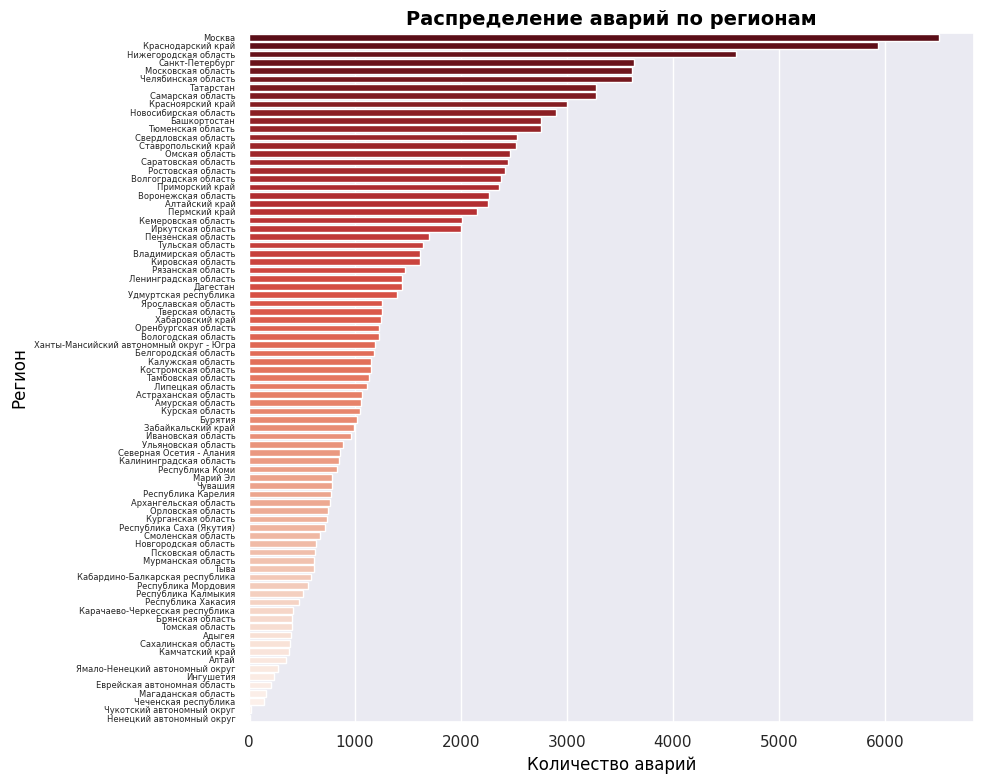

In [1248]:
sns.set(rc={'figure.figsize': (10, 8)})
counts = df['Регион'].value_counts().sort_values(ascending=False)
ranked = counts.rank(method='dense')
colors = plt.cm.Reds(ranked / ranked.max())
ax = sns.barplot(x=counts.values, y=counts.index, palette=colors)
plt.title("Распределение аварий по регионам", fontsize=14, fontweight="bold", color='black')
plt.xlabel("Количество аварий", fontsize=12, color='black')
plt.ylabel("Регион", fontsize=12, color='black')
plt.tick_params(axis='y', labelsize=6)
plt.tight_layout()
plt.show()

Соотношение погибших, раненых и потерпевших в ДТП за год по всей России:

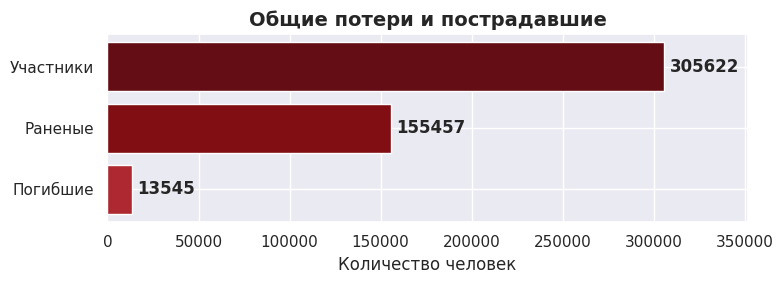

In [1249]:
categories = ['Погибшие', 'Раненые', 'Участники']
values = [df['Число погибших'].sum(), df['Число раненых'].sum(), df['Число участников'].sum()]

plt.figure(figsize=(8, 3))
bars = plt.barh(categories, values, color=['#ad2831', '#800e13', '#640d14'])

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + max(values)*0.01, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center', fontsize=12, fontweight='bold')

plt.title('Общие потери и пострадавшие', fontsize=14, fontweight='bold')
plt.xlabel('Количество человек', fontsize=12)
plt.xlim(0, max(values) * 1.15)
plt.tight_layout()
plt.show()

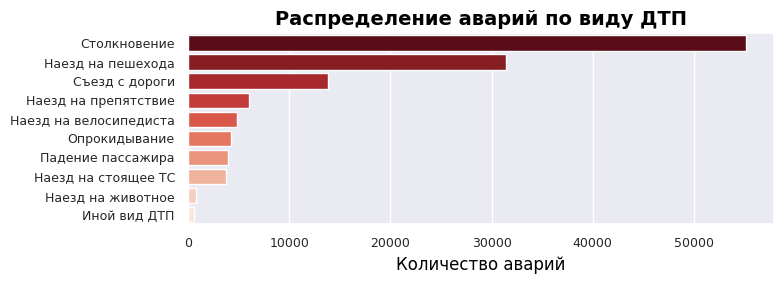

In [1250]:
sns.set(rc={'figure.figsize': (8, 3)})
counts = df['Вид ДТП'].value_counts().sort_values(ascending=False).head(10)
ranked = counts.rank(method='dense')
colors = plt.cm.Reds(ranked / ranked.max())
ax = sns.barplot(x=counts.values, y=counts.index, palette=colors)
plt.title("Распределение аварий по виду ДТП", fontsize=14, fontweight="bold", color='black')
plt.xlabel("Количество аварий", fontsize=12, color='black')
plt.ylabel("", fontsize=12, color='black')
plt.tick_params(axis='y', labelsize=9)
plt.tick_params(axis='x', labelsize=9)
plt.tight_layout()
plt.show()

На гистограме "Распределение аварий по месяцам" показано, что наибольшее количество аварий происходит в июле, августе и сентябре.

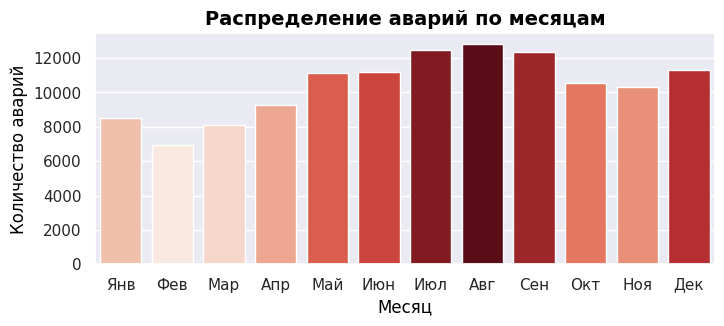

In [1251]:
sns.set(rc={'figure.figsize': (8, 3)})
counts = df['Месяц'].value_counts().sort_index()
ranked = counts.rank(method='dense')
colors = plt.cm.Reds(ranked / ranked.max())
sns.barplot(x=counts.index, y=counts.values, palette=colors)
plt.xticks(range(12), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.title("Распределение аварий по месяцам", fontsize=14, fontweight="bold", color='black')
plt.xlabel("Месяц", fontsize=12, color='black')
plt.ylabel("Количество аварий", fontsize=12, color='black')
plt.show()

На гистограме "Распределение аварий по дням недели" показано, что наибольшее количество аварий происходит в пятницу и субботу.

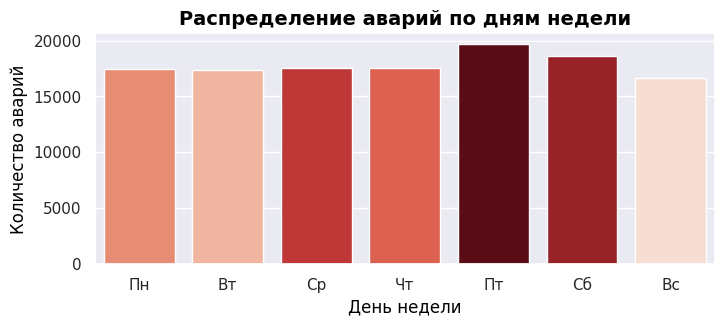

In [1252]:
sns.set(rc={'figure.figsize': (8, 3)})
counts = df['День недели'].value_counts().sort_index()
ranked = counts.rank(method='dense')
colors = plt.cm.Reds(ranked / ranked.max())
sns.barplot(x=counts.index, y=counts.values, palette=colors)
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.title("Распределение аварий по дням недели", fontsize=14, fontweight="bold", color='black')
plt.xlabel("День недели", fontsize=12, color='black')
plt.ylabel("Количество аварий", fontsize=12, color='black')
plt.show()


На гистограме "Распределение аварий по времени суток" показано, что большинство аварий происходит в период с 17:00 до 19:00.


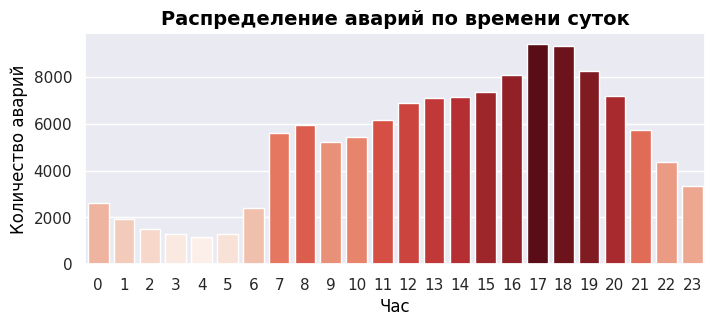

In [1253]:
sns.set(rc={'figure.figsize': (14, 3)})
sns.set(rc={'figure.figsize': (8, 3)})
counts = df['Час'].value_counts().sort_index()
ranked = counts.rank(method='dense')
colors = plt.cm.Reds(ranked / ranked.max())
sns.barplot(x=counts.index, y=counts.values, palette=colors)
plt.title("Распределение аварий по времени суток", fontsize=14, fontweight="bold", color='black')
plt.xlabel("Час", fontsize=12, color='black')
plt.ylabel("Количество аварий", fontsize=12, color='black')
plt.show()

На гистограме "Распределение аварий по освещению" показано, что наибольшее количество аварий происходит днем. На гистограме "Распределение тяжести последствий по освещению" показано, что ДТП с тяжкими последствиями происходят чаще всего в темное время суток

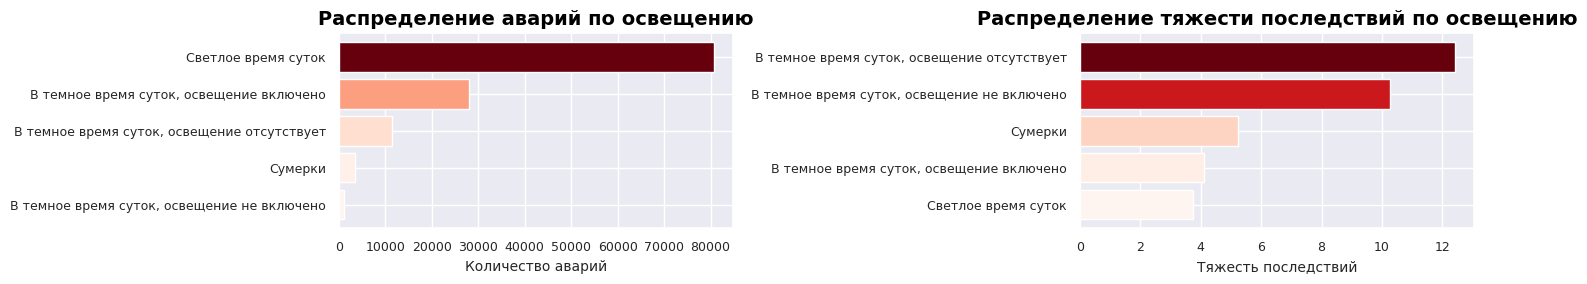

In [1254]:
summary = df.groupby('Освещение')['Тяжесть последствий'].agg(['mean', 'count'])
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
cmap = plt.cm.Reds

summary_sorted_count = summary.sort_values('count', ascending=True).tail(5)
norm_count = plt.Normalize(summary_sorted_count['count'].min(), summary_sorted_count['count'].max())
colors_count = cmap(norm_count(summary_sorted_count['count']))
axes[0].barh(summary_sorted_count.index, summary_sorted_count['count'], color=colors_count)
axes[0].set_title('Распределение аварий по освещению', fontsize=14, fontweight="bold", color='black')
axes[0].set_xlabel('Количество аварий', fontsize=10)
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=9)
axes[0].tick_params(axis='y', labelsize=9)

summary_sorted_mean = summary.sort_values('mean', ascending=True).tail(5)
norm_mean = plt.Normalize(summary_sorted_mean['mean'].min(), summary_sorted_mean['mean'].max())
colors_mean = cmap(norm_mean(summary_sorted_mean['mean']))
axes[1].barh(summary_sorted_mean.index, summary_sorted_mean['mean'], color=colors_mean)
axes[1].set_title('Распределение тяжести последствий по освещению', fontsize=14, fontweight="bold", color='black')
axes[1].set_xlabel('Тяжесть последствий', fontsize=10)
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

На гистограме "Распределение аварий по состоянию погоды" показано, что чаще всего аварии проссиходят в сухую и ясную погоду. Тяжесть последствий выше в ДТП, которые происходят в плохих погодных условиях.



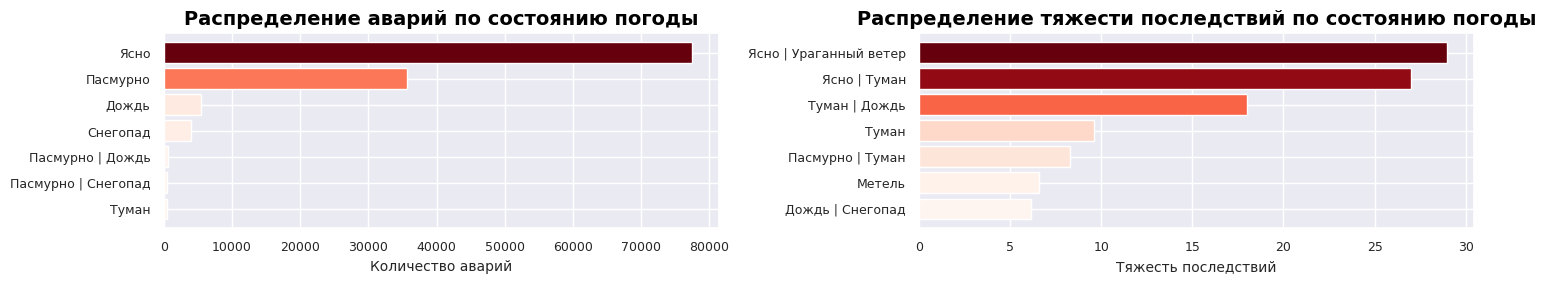

In [1255]:
summary = df.groupby('Состояние погоды')['Тяжесть последствий'].agg(['mean', 'count'])
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
cmap = plt.cm.Reds

summary_sorted_count = summary.sort_values('count', ascending=True).tail(7)
norm_count = plt.Normalize(summary_sorted_count['count'].min(), summary_sorted_count['count'].max())
colors_count = cmap(norm_count(summary_sorted_count['count']))
axes[0].barh(summary_sorted_count.index, summary_sorted_count['count'], color=colors_count)
axes[0].set_title('Распределение аварий по состоянию погоды', fontsize=14, fontweight="bold", color='black')
axes[0].set_xlabel('Количество аварий', fontsize=10)
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=9)
axes[0].tick_params(axis='y', labelsize=9)

summary_sorted_mean = summary.sort_values('mean', ascending=True).tail(7)
norm_mean = plt.Normalize(summary_sorted_mean['mean'].min(), summary_sorted_mean['mean'].max())
colors_mean = cmap(norm_mean(summary_sorted_mean['mean']))
axes[1].barh(summary_sorted_mean.index, summary_sorted_mean['mean'], color=colors_mean)
axes[1].set_title('Распределение тяжести последствий по состоянию погоды', fontsize=14, fontweight="bold", color='black')
axes[1].set_xlabel('Тяжесть последствий', fontsize=10)
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

На гистограме "Состояние проезжей части" показано, что наибольшее количество аварий происходит на сухой проезжей части. Тяжесть последствий выше в ДТП, если дорожное покрытие неидеально.

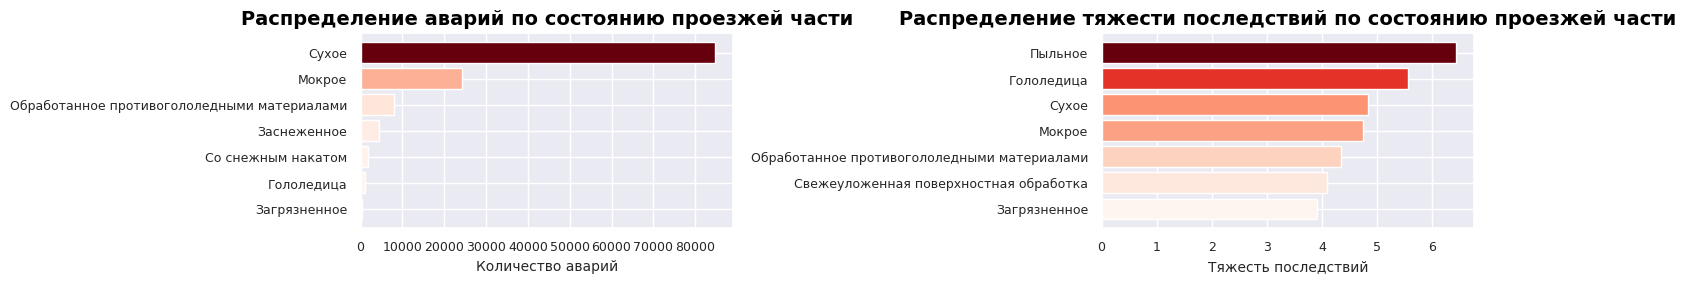

In [1256]:
summary = df.groupby('Состояние проезжей части')['Тяжесть последствий'].agg(['mean', 'count'])
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
cmap = plt.cm.Reds

summary_sorted_count = summary.sort_values('count', ascending=True).tail(7)
norm_count = plt.Normalize(summary_sorted_count['count'].min(), summary_sorted_count['count'].max())
colors_count = cmap(norm_count(summary_sorted_count['count']))
axes[0].barh(summary_sorted_count.index, summary_sorted_count['count'], color=colors_count)
axes[0].set_title('Распределение аварий по состоянию проезжей части', fontsize=14, fontweight="bold", color='black')
axes[0].set_xlabel('Количество аварий', fontsize=10)
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=9)
axes[0].tick_params(axis='y', labelsize=9)

summary_sorted_mean = summary.sort_values('mean', ascending=True).tail(7)
norm_mean = plt.Normalize(summary_sorted_mean['mean'].min(), summary_sorted_mean['mean'].max())
colors_mean = cmap(norm_mean(summary_sorted_mean['mean']))
axes[1].barh(summary_sorted_mean.index, summary_sorted_mean['mean'], color=colors_mean)
axes[1].set_title('Распределение тяжести последствий по состоянию проезжей части', fontsize=14, fontweight="bold", color='black')
axes[1].set_xlabel('Тяжесть последствий', fontsize=10)
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)

plt.tight_layout()
plt.show()

Построим модель машинного обучения, которая определяет влияние фактора на смертность при ДТП на примере трех факторов.


In [1257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


In [1258]:
X = df[['Плохие погодные условия', 'Ограниченное освещение', 'Неудовлетворительное состояние проезжей части']]
y = df['Смертность']

In [1259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [1260]:
model_rf = RandomForestClassifier(
    class_weight='balanced_subsample',
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

feature_importance_rf = pd.DataFrame({
    'Фактор': X.columns,
    'Важность': model_rf.feature_importances_
}).sort_values('Важность', ascending=False)

print("\nRandom Forest - важность факторов:")
print(feature_importance_rf)


Random Forest - важность факторов:
                                          Фактор  Важность
1                         Ограниченное освещение  0.936013
2  Неудовлетворительное состояние проезжей части  0.044381
0                        Плохие погодные условия  0.019606


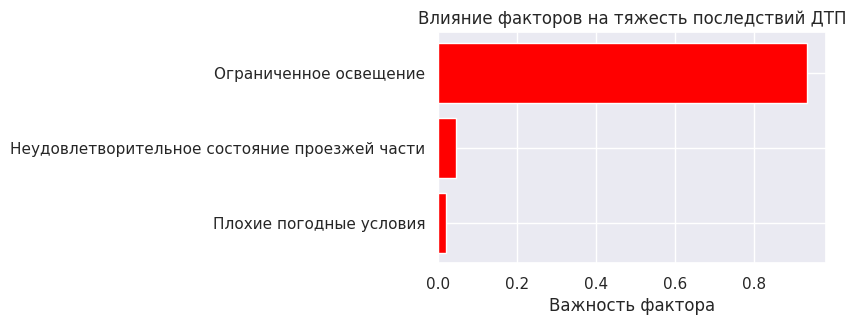

In [1261]:
plt.figure(figsize=(5, 3))
colors_count = cmap(norm_count(summary_sorted_count['count']))
bars = plt.barh(feature_importance_rf['Фактор'], feature_importance_rf['Важность'], color='Red')
plt.xlabel('Важность фактора')
plt.title('Влияние факторов на тяжесть последствий ДТП')
plt.gca().invert_yaxis()

In [1262]:
model_rf.fit(X_train, y_train)
y_pred_train = model_rf.predict(X_train)
y_pred_test = model_rf.predict(X_test)

In [1263]:
print(f'model train accuracy {accuracy_score(y_train, y_pred_train):.3f}')
print(f'model test accuracy {accuracy_score(y_test, y_pred_test):.3f}')

model train accuracy 0.644
model test accuracy 0.643


In [1264]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     90669
           1       0.13      0.48      0.20      9257

    accuracy                           0.64     99926
   macro avg       0.53      0.57      0.49     99926
weighted avg       0.85      0.64      0.72     99926

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     22668
           1       0.13      0.48      0.20      2314

    accuracy                           0.64     24982
   macro avg       0.53      0.57      0.49     24982
weighted avg       0.85      0.64      0.72     24982



Качество освещения из трех факторов влияет на тяжесть последствий при ДТП больше всего.
Точность модели на обучающей выборке составляет 0,644, на тестовой выборке - 0,643. Это говорит о том, что модель не переобучена.

В результате исследования, можем сделать вывод:
1. Большинство аварий происходит летом и осенью, а не зимой, как предполагалось.
2. Влияние погоды на количество аварий и тяжесть при ДТП не подтвердилось.
3. Плохое дорожное покрытие в меньшей степени влияет на количество аварий и тяжесть последствий.
4. Тяжесть последствий ДТП зависит от освещения на дорогах.


In [1265]:
df.to_csv('/content/drive/MyDrive/Data/Crash.csv', index=False, sep=',')